# Explore here

In [ ]:
import pandas as pd
import numpy as np, random
import statsmodels.api as sm
import datetime
#https://4geeks.com/es/syllabus/spain-ds-pt-10/project/alternative-time-series-project
'''Sistema de predicción de ventas
Queremos establecer el almacén de nuestra empresa en otra localización 
y necesitamos estimar el ritmo de las ventas, que desde la creación de la empresa ha ido en aumento,
para los próximos meses, a fin de proveer el espacio que necesitaremos'''

In [2]:
'''
Paso 1: Carga del conjunto de datos
'''
df_rd = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv")
df_rd.to_csv("/workspaces/Proyecto-JBG.SerieTemporalAlternativa/data/raw/df_rd.csv", index=False)
df_rd.head(4)

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899


In [3]:
#PASO 1, DARLE FORMATO A LA FECHA DE LAS MUESTRAS.
df_rd["dateYMD"] = pd.to_datetime(df_rd["date"], format='mixed')
df_rd["dateYMD"] = df_rd["dateYMD"].dt.date
df_rd.head(3),



(                         date      sales     dateYMD
 0  2022-09-03 17:10:08.079328  55.292157  2022-09-03
 1  2022-09-04 17:10:08.079328  53.803211  2022-09-04
 2  2022-09-05 17:10:08.079328  58.141693  2022-09-05,)

In [4]:
#Ya tenemos nuestra columnas de fechas con el formato YMD.
#dropeamos la columna antigua de fechas.
df_rd_YMD = df_rd.drop("date", axis=1)
df_rd_YMD.to_csv("/workspaces/Proyecto-JBG.SerieTemporalAlternativa/data/raw/df_rd.csv", index=False)
df_rd_YMD.head(3),

(       sales     dateYMD
 0  55.292157  2022-09-03
 1  53.803211  2022-09-04
 2  58.141693  2022-09-05,)

In [5]:
#Vamos a poner la columna dateYMD como indice default del dataframe, creando un dataframe con indice en formato
#fecha y una sola columna con las ventas'sales'
df_rd_YMD = df_rd_YMD.set_index('dateYMD')
df_ds = df_rd_YMD[['sales']]
df_ds.to_csv("/workspaces/Proyecto-JBG.SerieTemporalAlternativa/data/raw/df_rd_indexed.csv", index=True)
df_ds.head(3)


,sales
dateYMD,
2022-09-03,55.292157
2022-09-04,53.803211
2022-09-05,58.141693


NameError: name 'trend' is not defined

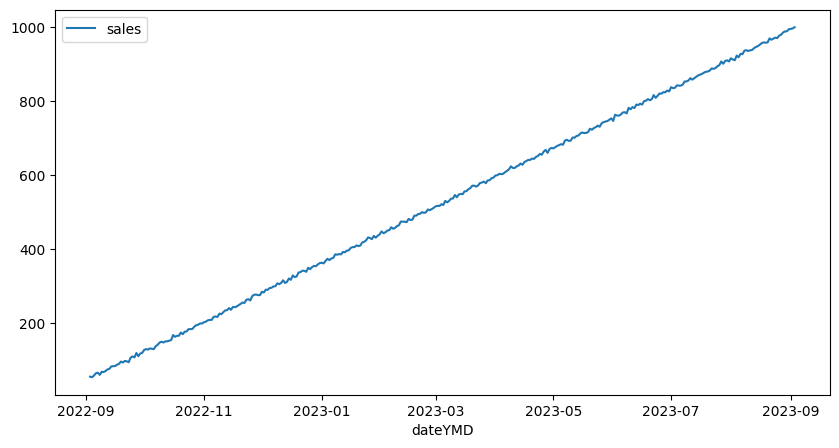

In [17]:
#vamos a graficar nuestros datos.
import matplotlib.pyplot as plt
import seaborn as sns
fig, axis = plt.subplots(figsize = (10, 5))
sns.lineplot(data = df_ds)
sns.lineplot(data = trend)
plt.tight_layout()
plt.show()

In [ ]:
'''
Paso 2: Construye y analiza la serie temporal
Construye la estructura de datos válida para la serie temporal, grafícala y, a continuación, analízala y responde a las siguientes preguntas:
A¿Cuál es el tensor de la serie temporal? El tensor de la unidad temporal son dias, en concreto es una serie de datos comprendidos en 366 tensores, 366 dias.
B¿Cuál es la tendencia? La tendencia es lineal positiva, la grafica incrementa de valor dia a dia, presenta ruidos(valores que decrementan e incrementan localmente pero muy leves). En general los valores van incrementando linealmente de forma positiva.
C¿Es estacionaria? Si, completa el ciclo de un año comprendido en 366 muestras, acabando un ciclo.
D¿Existe variabilidad o presencia de ruido? Apenas perceptible, el ruido que presenta es de poca intensidad y se aprecia claramente una linea en incremento.
'''
numero_de_muestras = df_ds['sales'].count()
numero_de_muestras

np.int64(366)

In [16]:
'''
Paso 3: Entrena un ARIMA:
Utiliza los datos de entrenamiento para encontrar la mejor parametrización de tu modelo ARIMA.
Vamos a analizar el timeseries con la prueba dickey-fuller y ver si es o no estacionaria en funcion de los resultados,
despues realizar un seasonal decompose para poder trabajar estadisticamente con los datos.
'''

from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(df_ds)









'''
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_ds, period = 366)
decomposition
'''

Resultados de la prueba de Dickey-Fuller:


'\nfrom statsmodels.tsa.seasonal import seasonal_decompose\ndecomposition = seasonal_decompose(df_ds, period = 366)\ndecomposition\n'